# Loading image data

### Loading libraries

In [1]:
# To use CUDA
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch import nn
from torch import optim
import torch.nn.functional as F
from PIL import Image
from torchvision import datasets, transforms, models
# To import helper
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
import helper
# To import the cat dog dataset
! wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
! unzip Cat_Dog_data

Output hidden; open in https://colab.research.google.com to view.

### Loading image files

In [0]:
# Transforms here
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
# Create imageFolders and DataLoader
data_dir ='/content/Cat_Dog_data'
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Testing dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


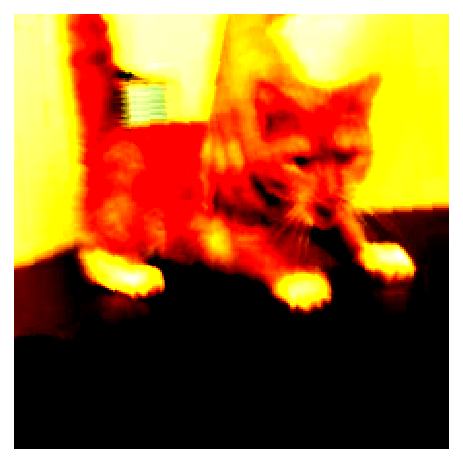

In [3]:
# To show dataloader
images, labels = next(iter(trainloader))
helper.imshow(images[0], normalize=False)

 ### Data augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


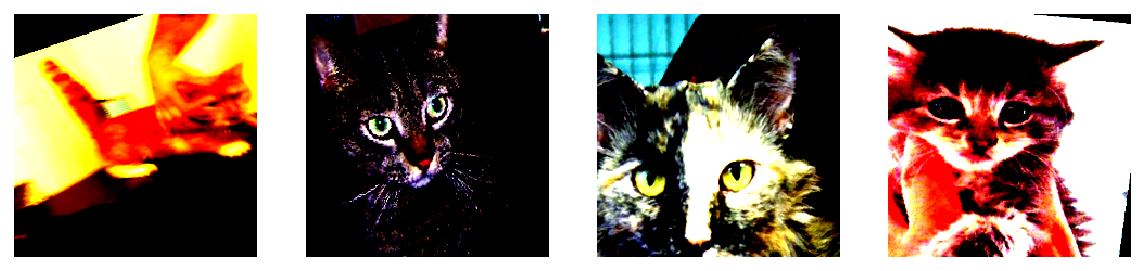

In [4]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

### Loading the dense model

In [5]:
model = models.densenet121(pretrained=True)
# Freeze parameters to not backprop through them
for param in model.parameters():
    param.requires_grad = False
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))    
model.classifier = classifier
model.to('cuda')
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 29.0MB/s]


### Training and validation

In [6]:
epochs = 1
steps = 0
for e in range(epochs):
    running_loss = 0
    running_loss_test = 0
    for images, labels in trainloader:
        # Move images and label tensors to cuda (GPU).
        images, labels = images.to('cuda'), labels.to('cuda')
        # Training
        optimizer.zero_grad()      
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()        
    else:
        #Showing the training loss
        print(f"Training loss: {running_loss/len(trainloader)}")          
        # turn off gradients
        with torch.no_grad():        
            # set model to evaluation mode
            model.eval()
            # validation pass here
            for images, labels in testloader:
                # Move images and label tensors to cuda (GPU).
                images, labels = images.to('cuda'), labels.to('cuda')
                #Showing the test loss
                log_ps_test = model(images)
                loss_test = criterion(log_ps_test, labels)
                running_loss_test += loss_test.item()
            else:
                print(f"Test loss: {running_loss_test/len(testloader)}")                
                #To calculate accuracy
                # Get the class probabilities
                ps = torch.exp(model(images))
                #To obtain the class with the highest probability using method ps.topk
                top_p, top_class = ps.topk(1, dim=1)
                #Now we want to check that the class obtained in the probabilities with the model correspond to the labels
                equals = top_class == labels.view(*top_class.shape)
                #Accuracy is a mean of how much the model got right
                accuracy = torch.mean(equals.type(torch.FloatTensor))               
                print(f'Accuracy: {accuracy.item()*100}%')            
                # set model back to train mode
                model.train()   

Training loss: 0.21745031544031174
Test loss: 3.6028462034650146
Accuracy: 100.0%
